# This files runs study 1, clear winner case, with social networks

- Class network_MAB contains both TS and static design methods.
- G1 is the simulated social network

In [ ]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from numpy.core.fromnumeric import repeat
from scipy import stats
import seaborn as sns
import pandas as pd
import scipy.stats as st

## First we need to generate a social network.

Data source: https://snap.stanford.edu/data/ego-Facebook.html

There are 4039 nodes in total.

Do 5000 simulations and check expectation and variance.

In [ ]:
!pip install networkx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import networkx as nx

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls

drive  sample_data


In [ ]:
%cd drive/MyDrive

/content/drive/MyDrive


In [ ]:
!ls

 37240759_eTranscript.pdf
 37558593_eTranscript.pdf
 40074140_eTranscript.pdf
'ADA final Group 32.gdoc'
'Basic Timesheet.gsheet'
'Colab Notebooks'
 critique.gdoc
'CV_Siyi Gao.pdf'
 data_cleaning_utils.py
'data science project experience_Siyi Gao.md'
'descriptions of an experiment.gdoc'
'Exam 3.gdoc'
'experimental design.gdoc'
 facebook_combined.txt
'Final paper for psychology.gdoc'
'Gao Siyi-CV.pdf'
 gr5067_finalproject-main
'hw2 proposal.gdoc'
 internship.docx
'Multi-arm bandit problem in marketing domain.gdoc'
'Neighborhood Noise Survey.gform'
'NLP presentation.gslides'
'Noise project weekly summary.gdoc'
 psychology_final_paper-2022-08-09-23-33.gdoc
 __pycache__
'Report (1).gdoc'
'Report (2).gdoc'
 Report.gdoc
'Siyi Gao_eTranscript.pdf'
'Transcript1-Siyi Gao.pdf'
'Transcript-Siyi Gao.pdf'
'Travel and Business Expense Report Form (TBER) Rev010720 .gsheet'
'Untitled presentation.gslides'
'week 10 notes.gdoc'
 week8_notes.gdoc
'Week 9 (final version).gslides'


In [ ]:
G1 =nx.read_edgelist("facebook_combined.txt", create_using = nx.Graph(), nodetype=int)
neigh = [1,20,40,65,75,90,1000]
for i in range(len(neigh)):
    all_neighbors = list(nx.classes.function.all_neighbors(G1,neigh[i]))
    print("All neighbors for Node ", str(neigh[i])," ---> ", str(all_neighbors))

All neighbors for Node  1  --->  [0, 48, 53, 54, 73, 88, 92, 119, 126, 133, 194, 236, 280, 299, 315, 322, 346]
All neighbors for Node  20  --->  [0, 2, 14, 41, 44, 111, 115, 149, 162, 214, 226, 312, 326, 333, 343]
All neighbors for Node  40  --->  [0, 21, 25, 26, 29, 56, 67, 72, 77, 113, 132, 133, 141, 142, 158, 169, 172, 199, 200, 203, 212, 213, 224, 231, 232, 239, 257, 258, 265, 271, 272, 274, 277, 280, 298, 304, 307, 315, 317, 322, 325, 329, 332, 334]
All neighbors for Node  65  --->  [0, 7, 13, 25, 82, 118, 203, 252, 261, 297, 314, 339]
All neighbors for Node  75  --->  [0, 9, 56, 67, 85, 170, 188, 200, 258, 272, 274, 304, 322, 323]
All neighbors for Node  90  --->  [0, 179]
All neighbors for Node  1000  --->  [107, 924, 974, 985, 1010, 1127, 1134, 1228, 1304, 1474, 1640, 1667, 1703, 1725, 1759, 1840]


In [ ]:
!pip install scipy==1.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41.6 MB 1.4 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3


In [ ]:
import matplotlib.pyplot as plt
d = nx.degree(G1)

Text(0.5, 1.0, 'Social Network Graph')

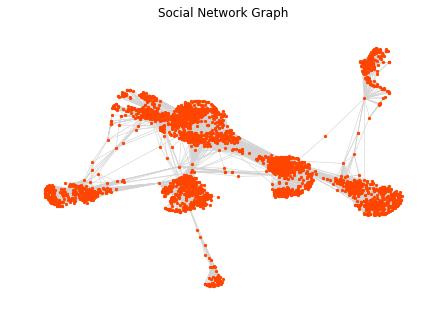

In [ ]:
nx.draw(G1, pos=nx.spring_layout(G1),node_size=5,node_color='orangered',edge_color='lightgrey',width=0.6)
plt.title("Social Network Graph")

In [ ]:
class network_MAB:
    def __init__(self, probs, karms, nfirst, nEpisodes, nets, augment):
        '''
        meanings for the parameters:
        probs: True success rate for each arm k in {1, ..., K} 
        kArms: Number of arms to choose among
        nsamples: Number of subjects to test at each time step
        random_seed: Store the number of seed for replication

        '''
 
        self.network = nets
        self.sample_indexs = list(range(4039))
        self.selection = []
        self.left = list(range(4039))
        self.neighbors = set()
        self.augment = augment

        self.n_obs = 4000
        self.probs = probs
        self.K = karms
        self.n = int((self.n_obs-nfirst)/(nEpisodes-1)) if nEpisodes > 1 else 0
        self.T = nEpisodes
        self.first = nfirst
        self.true_win_arm = np.argmax(np.asarray(probs))


    def best_arm(self, s, asgn):
        draws = 10000
        # + 1 for a Beta(1, 1) prior
        new_alpha = s+1
        new_beta = asgn-s+1
        selection_table = []
        for i in range(self.K):
            theta = np.random.beta(new_alpha[i], new_beta[i], draws)
            selection_table.append(theta)

        winning_arms = np.argmax(selection_table, axis = 0)
        winning_prob = []

        c = Counter(winning_arms)
        winning_prob = []
        for i in range(self.K):
            winning_prob.append(c[i]/draws)

        return np.array(winning_prob)

    def experiment(self, winning_probs, sampleSize, static = False):  
        # update sample information
        rest = self.left
        x = np.random.choice(rest, size=sampleSize, replace=False)
        self.selection.append(x)
        self.left = list(set(rest) - set(x))   

        # random assignment

        if not static:
            # print(type(self.n),type(winning_probs))
            new_assign = np.random.choice(range(self.K), size=sampleSize, p=list(winning_probs))
        else:
            new_assign = np.random.choice(range(self.K), size=sampleSize)
        # count number of assigned subjects
        c = Counter(new_assign)
        assigned = [c[i] for i in range(self.K)]

        success = [0]*self.K
        # print('self.probs',self.probs, '\n new assign',new_assign)
        # new_assign: array of group assignment of each sample

        # do experiment
        for i in range(len(x)):
            if x[i] in self.neighbors:
                success_probs = self.probs[new_assign[i]]+ self.augment
                success[new_assign[i]] += np.random.binomial(1,success_probs,1)[0]
            else:
                success_probs = self.probs[new_assign[i]]
                success[new_assign[i]] += np.random.binomial(1,success_probs,1)[0]
            
        # update information again
        new_neighbors = []
        for i in x:
            new_neighbors += list(nx.classes.function.all_neighbors(G1,i))      
        
        self.neighbors.update(set(new_neighbors))
        # print(success)
        return (assigned, success)

    def reset(self):
    # initialization
        success = np.zeros((self.T, self.K))   # record the success cases of each arm at each time step
        assigned = np.zeros((self.T, self.K)) # record the assigned cases of each arm at each time step
        posterior_probs = 0 # estimated success rate
        winning_probs = np.zeros((self.T, self.K)) # probability to be the true best arm
        # rewards = np.zeros(self.T) # record the average rewards per period
        # regrets = np.zeros(self.T) # record the regrets per period
        self.selection = []
        self.left = list(range(4039))
        self.neighbors = set()
        return (success, assigned, posterior_probs, winning_probs)

    def Thompson_sampling(self):
        # initialization
        (success, assigned, posterior_probs, winning_probs) = self.reset()

        # for round 1, samples are randomly assigned
        # new_assign = np.random.choice(range(self.K), size=self.first)
        assigned[0], success[0]  = self.experiment(1/self.K,self.first,static=True)
        # print(success[0,0],assigned[0,0])
        posterior_probs = success[0,0]/ assigned[0,0]
        winning_probs[0] = self.best_arm(success[0], assigned[0])
        adj_probs = success[0][0]*self.K/self.first
        # print(adj_probs)
        if self.T > 1:
            count0 = 0
            for i in range(1, self.T):              
                # new_assign = np.random.choice(range(self.K), size=self.n, p=list(winning_probs[i-1])) # adaptive design
                new_assigned, new_success = self.experiment(winning_probs[i-1],self.n)
                assigned[i] = assigned[i-1]+ new_assigned
                success[i] = success[i-1]+ new_success
                winning_probs[i] = self.best_arm(success[i], assigned[i])
                if winning_probs[i-1,0] == 0:
                    count0 += 1
                else:
                    adj_probs += new_success[0]/winning_probs[i-1,0]/self.n
            posterior_probs = adj_probs / (self.T-count0)
        return (success, assigned, posterior_probs, winning_probs)
    


    def static(self):
        # initialization
        (success, assigned, posterior_probs, winning_probs) = self.reset()

        # for round 1, samples are randomly assigned
        # new_assign = np.random.choice(range(self.K), size=self.first).tolist()
        assigned[0], success[0]  = self.experiment(1/self.K,self.first,static=True)
        posterior_probs = success[0,0]/ assigned[0,0]
        winning_probs[0] = self.best_arm(success[0], assigned[0])
        adj_probs = success[0][0]*self.K/self.first
        for i in range(1, self.T):
            # new_assign = np.random.choice(range(self.K), size=self.n).tolist() # static design
            new_assigned, new_success = self.experiment(1/self.K, self.n, static = True)
            assigned[i] = assigned[i-1]+ new_assigned
            success[i] = success[i-1]+ new_success
            winning_probs[i] = self.best_arm(success[i], assigned[i])
            adj_probs += new_success[0]*self.K/self.n
        posterior_probs = adj_probs / self.T


        return (success, assigned, posterior_probs, winning_probs)
        
    def do_replication(self, times, method):
        '''
        parameters:
        final_regrets -- to record the final regret of each replication, in order to compare efficiency
        final_win_arm -- to record the final win arm selected by two methods, in order to compare the accurarcy
        final_win_probs -- to record the final probability of each arm being the best arm, in order to compare the accurarcy
        final_assignment -- to record the final number of assigned subjects to the true best arm, comparing the exploitition
        cum_rewards -- to record the total rewards of every replication
        '''
        # records of the replication
        final_win_arm = np.zeros(times)
        final_win_probs = np.zeros(shape = (times, self.K))
        final_assignment = np.zeros(times) # only record the true best arm
        estimation = np.zeros(times)
        
        if method == 'TS':
            for i in range(times):
                (success, assigned, posterior_probs, winning_probs) = self.Thompson_sampling()
                final_win_arm[i] = np.argmax(winning_probs[-1])
                final_win_probs[i] = winning_probs[-1]
                final_assignment[i] = assigned[-1][self.true_win_arm]
                estimation[i] = posterior_probs
        else:
            for i in range(times):
                (success, assigned, posterior_probs, winning_probs) = self.static()
                final_win_arm[i] = np.argmax(winning_probs[-1])
                final_win_probs[i] = winning_probs[-1]
                final_assignment[i] = assigned[-1][self.true_win_arm]
                estimation[i] = posterior_probs

        ate = np.mean(estimation)
        mse = np.mean(np.square(np.subtract(estimation,self.probs[0])))
        rmse = np.sqrt(mse)
        # rmse = np.std(estimation,0)
        # coverage = best_coverage(estimation, 5000,100,self.probs[0])
        low,high=st.t.interval(0.95, len(estimation)-1, loc=np.mean(estimation), scale=st.sem(estimation))
        win_counts = Counter(final_win_arm)
        estimate = {"best_selected":win_counts[0]/times,"ATE":ate, "RMSE":rmse, "CI":(low,high)}
        print(estimate)
        return (final_win_arm, final_win_probs, final_assignment, estimation)
    

In [ ]:
# experiment 1
k = 9 # number of treatments
probs = [0.2] + [0.1]*8 # true value
np.random.seed(99332)
first = 4000
periods = 1

In [ ]:
first = 4000
periods = 1
sim1 = network_MAB(probs,k,first, periods,G1,0.2)
(s1_ts_final_win_arm, s1_ts_final_win_probs, s1_ts_final_assignment, s1_ts_estimation) = sim1.do_replication(5000, "TS")
# (s1_st_final_win_arm, s1_st_final_win_probs, s1_st_final_assignment, s1_st_estimation) = sim1.do_replication(5000, "static")

{'best_selected': 1.0, 'ATE': 0.1999074607335638, 'RMSE': 0.01902145997799012, 'CI': (0.19938004826200081, 0.2004348732051268)}


In [ ]:
first = 2000
periods = 2
sim2 = network_MAB(probs,k,first, periods,G1,0.2)
(s2_ts_final_win_arm, s2_ts_final_win_probs, s2_ts_final_assignment, s2_ts_estimation) = sim2.do_replication(5000, "TS")
(s2_st_final_win_arm, s2_st_final_win_probs, s2_st_final_assignment, s2_st_estimation) = sim2.do_replication(5000, "static")

{'best_selected': 0.9996, 'ATE': 0.29777003000996044, 'RMSE': 0.09901728214409332, 'CI': (0.2973356324654087, 0.2982044275545122)}
{'best_selected': 0.997, 'ATE': 0.29807145, 'RMSE': 0.10136739003496144, 'CI': (0.29736055377578824, 0.2987823462242118)}


In [ ]:
first = 800
periods = 5
sim3 = network_MAB(probs,k,first, periods,G1,0.2)
(s3_ts_final_win_arm, s3_ts_final_win_probs, s3_ts_final_assignment, s3_ts_estimation) = sim3.do_replication(5000, "TS")
(s3_st_final_win_arm, s3_st_final_win_probs, s3_st_final_assignment, s3_st_estimation) = sim3.do_replication(5000, "static")

{'best_selected': 0.9912, 'ATE': 0.3542996923716937, 'RMSE': 0.15870522828902023, 'CI': (0.35327004943980744, 0.3553293353035799)}
{'best_selected': 0.9974, 'ATE': 0.35428185, 'RMSE': 0.15674220861816385, 'CI': (0.35351482788476807, 0.35504887211523195)}


In [ ]:
# Here
first = 400
periods = 10
sim4 = network_MAB(probs,k,first, periods,G1,0.2)
(s4_ts_final_win_arm, s4_ts_final_win_probs, s4_ts_final_assignment, s4_ts_estimation) = sim4.do_replication(5000, "TS")
(s4_st_final_win_arm, s4_st_final_win_probs, s4_st_final_assignment, s4_st_estimation) = sim4.do_replication(5000, "static")

{'best_selected': 0.9762, 'ATE': 0.3708917421547082, 'RMSE': 0.18023287259156576, 'CI': (0.3693037730704623, 0.3724797112389541)}
{'best_selected': 0.9954, 'ATE': 0.3715632, 'RMSE': 0.17392805286957017, 'CI': (0.37077063976609576, 0.3723557602339042)}


In [ ]:
first = 200
periods = 20
sim5 = network_MAB(probs,k,first, periods,G1,0.2)
(s5_ts_final_win_arm, s5_ts_final_win_probs, s5_ts_final_assignment, s5_ts_estimation) = sim5.do_replication(5000, "TS")
(s5_st_final_win_arm, s5_st_final_win_probs, s5_st_final_assignment, s5_st_estimation) = sim5.do_replication(5000, "static")

{'best_selected': 0.977, 'ATE': 0.3787980276721322, 'RMSE': 0.18678828591642568, 'CI': (0.3772994230794229, 0.38029663226484156)}
{'best_selected': 0.9946, 'ATE': 0.3790197000000001, 'RMSE': 0.1813143567812544, 'CI': (0.37822239734461244, 0.3798170026553878)}


In [ ]:
first = 80
periods = 50
sim6 = network_MAB(probs,k,first, periods,G1,0.2)
(s6_ts_final_win_arm, s6_ts_final_win_probs, s6_ts_final_assignment, s6_ts_estimation) = sim6.do_replication(5000, "TS")
(s6_st_final_win_arm, s6_st_final_win_probs, s6_st_final_assignment, s6_st_estimation) = sim6.do_replication(5000, "static")

{'best_selected': 0.986, 'ATE': 0.38340219325105945, 'RMSE': 0.18713526864172128, 'CI': (0.38237094997834614, 0.38443343652377276)}
{'best_selected': 0.995, 'ATE': 0.38386035, 'RMSE': 0.18607159505819257, 'CI': (0.3830673173965589, 0.3846533826034411)}


In [ ]:
first = 40
periods = 100
sim7 = network_MAB(probs,k,first, periods,G1,0.2)
(s7_ts_final_win_arm, s7_ts_final_win_probs, s7_ts_final_assignment, s7_ts_estimation) = sim7.do_replication(5000, "TS")
(s7_st_final_win_arm, s7_st_final_win_probs, s7_st_final_assignment, s7_st_estimation) = sim7.do_replication(5000, "static")

<ipython-input-72-a347d553d3bd>:109: RuntimeWarning: invalid value encountered in double_scalars
  posterior_probs = success[0,0]/ assigned[0,0]


{'best_selected': 0.9902, 'ATE': 0.38505275245730675, 'RMSE': 0.18668355002712217, 'CI': (0.38437005355879245, 0.38573545135582105)}


<ipython-input-72-a347d553d3bd>:137: RuntimeWarning: invalid value encountered in double_scalars
  posterior_probs = success[0,0]/ assigned[0,0]


{'best_selected': 0.9946, 'ATE': 0.38392065000000014, 'RMSE': 0.1861782762233555, 'CI': (0.38311916274647245, 0.38472213725352783)}
